# Análise de série temporal

In [1]:
# gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Dict
import matplotlib.ticker as mtick

In [2]:
# series temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
df_mensal = pd.read_excel('../data/faturamento.xlsx', sheet_name='Mes', header=None)
df_mensal.columns = ['data', 'faturamento']
df_mensal['data'] = pd.to_datetime(df_mensal['data'])

In [4]:
df = df_mensal.set_index('data')
df = df.asfreq('MS')

In [5]:
df['log_faturamento'] = np.log(df['faturamento'])

In [52]:
def create_month_dummies(df, months_to_track):
    """
    Cria colunas dummy (0 ou 1) para os meses especificados.
    :param df: DataFrame com índice temporal.
    :param months_to_track: Lista de meses (números 1 a 12). Ex: [3, 11, 12].
    :return: DataFrame com as novas colunas dummy.
    """
    df_with_dummies = df.copy()
    
    # 1. Extrair o mês do índice
    months = df.index.month
    
    for month in months_to_track:
        col_name = f'mes_{month}'
        # Cria a coluna, 1 se o mês for o especificado, 0 caso contrário
        df_with_dummies[col_name] = (months == month).astype(int)
        
    return df_with_dummies

In [53]:
MONTHS_OF_INTEREST = [3, 11, 12]
df = create_month_dummies(df, MONTHS_OF_INTEREST)

## Detecção da estacionariedade

In [6]:
teste_adf = adfuller(df['faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.4842 (p-value: 0.0002)


In [7]:
teste_adf = adfuller(df['log_faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.1896 (p-value: 0.0007)


## Identificação

- AR (p)

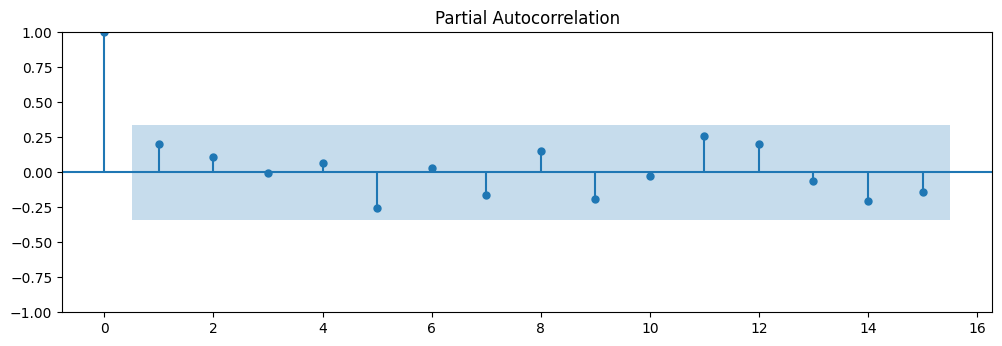

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'], lags=15, ax=ax1)

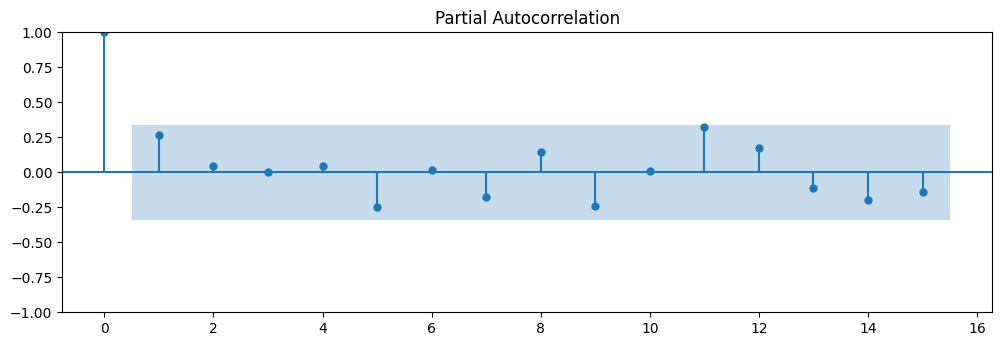

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']), lags=15, ax=ax1)

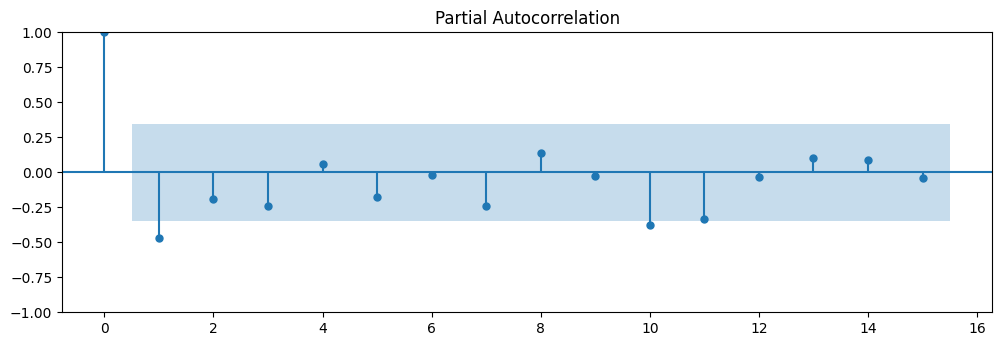

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

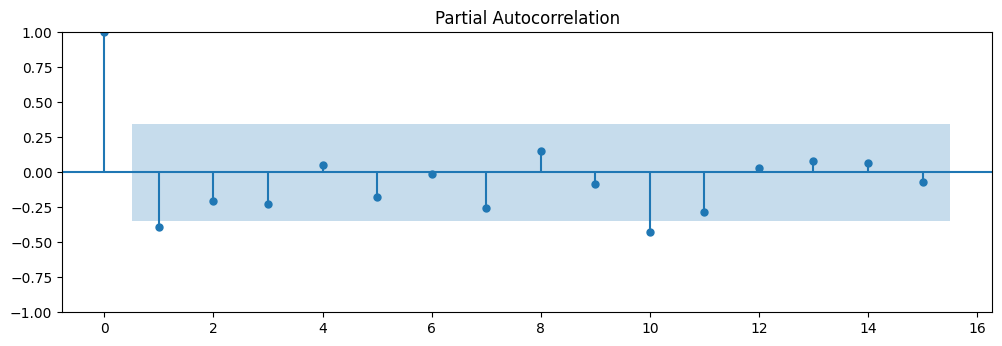

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

- MA(q)

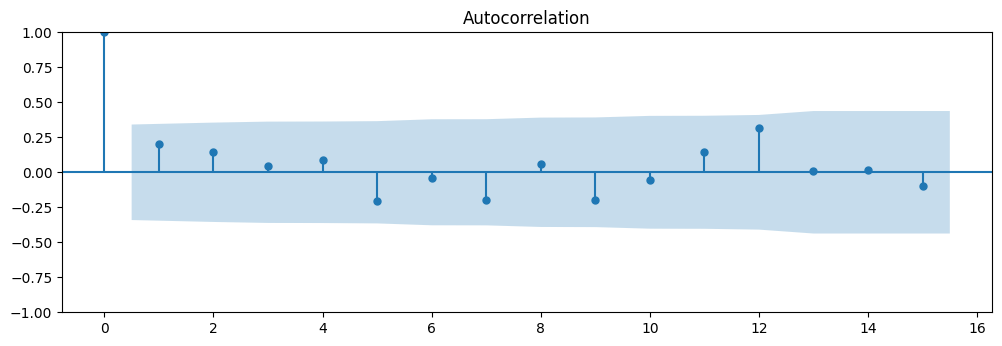

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'], lags=15, ax=ax1)

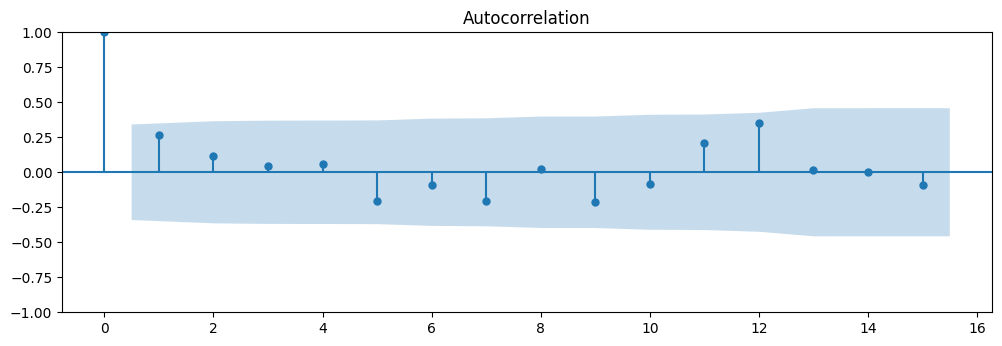

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']), lags=15, ax=ax1)

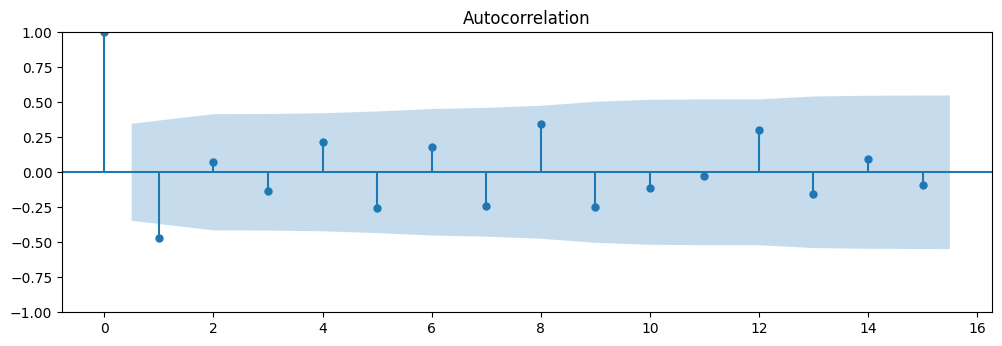

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

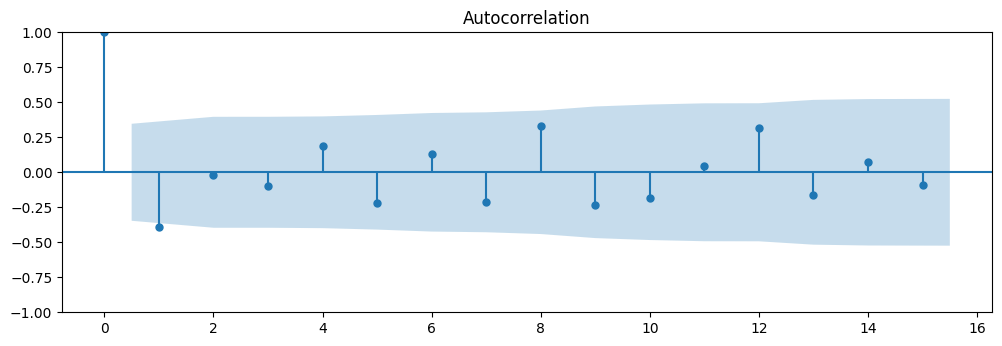

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

## Modelo Box-Jenkins

(vamos tentar mesmo assim)

In [16]:
def create_sparse_mask(ar_lags=None, ma_lags=None, sar_lags=None, sma_lags=None):
    """
    Cria os vetores de máscara de parâmetros para o SARIMAX.
    Exemplo: ar_lags=[1, 10] para p=10.
    """
    # Ordem total p, q, P, Q
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    
    # Inicializa as máscaras (tamanho = p ou q)
    ar_mask = np.zeros(p)
    ma_mask = np.zeros(q)
    
    # 1. Máscara AR
    if ar_lags:
        for lag in ar_lags:
            if lag > 0 and lag <= p:
                # O índice do numpy é lag - 1
                ar_mask[lag - 1] = 1
                
    # 2. Máscara MA
    if ma_lags:
        for lag in ma_lags:
            if lag > 0 and lag <= q:
                ma_mask[lag - 1] = 1
                
    # Sazonal (Deixando como vazio, pois não foi pedido no MA)
    sar_mask = np.array([]) 
    sma_mask = np.array([])
    
    return ar_mask, ma_mask, sar_mask, sma_mask

In [17]:
def build_sarimax_constraints(initial_model, param_mask):
    """
    Cria o dicionário de parâmetros que devem ser fixados em 0.0, 
    usando os nomes reais dos parâmetros do modelo.
    """
    param_names = initial_model.param_names
    
    # Validação crucial
    if len(param_names) != len(param_mask):
         raise ValueError(f"Tamanho da máscara ({len(param_mask)}) não coincide com o número de parâmetros do modelo ({len(param_names)}). Verifique o 'trend' e as ordens.")
         
    fixed_params_dict = {}
    
    # Itera sobre os nomes e a máscara
    for name, is_active in zip(param_names, param_mask):
        if is_active == 0:
            # Se a máscara for 0, adicione o parâmetro ao dicionário com valor fixo 0.0
            fixed_params_dict[name] = 0.0
            
    return fixed_params_dict

In [18]:
def train_sarimax(historico,
                  coluna_valor, 
                  periodo_inicial, 
                  horizonte=1, 
                  order=(1, 1, 1), 
                  seasonal_order=(0, 0, 0, 0)):
    
    model = SARIMAX(
        historico[coluna_valor],
        order=order,
        seasonal_order=seasonal_order,
        trend='n',
        enforce_stationarity=False,
        enforce_invertibility=False
    )
            
    # Ajustar o modelo (fit)
    model_fit = model.fit(disp=False) # disp=False para não imprimir o log de convergência

    return model_fit

In [19]:
def train_sarimax_sparse(historico,
                         coluna_valor, 
                         periodo_inicial, 
                         horizonte=1, 
                         ar_lags=[1, 10], 
                         ma_lags=[1], 
                         d=1,
                         seasonal_order=(0, 0, 0, 0)):
    
    # 1. Definir a ordem p, q e as máscaras fixas para o loop
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    
    # Ordem principal do modelo
    order = (p, d, q)

    # Cria as máscaras para a estimação esparsa
    ar_mask, ma_mask, sar_mask, sma_mask = create_sparse_mask(ar_lags, ma_lags)

    # Concatena todas as máscaras (AR, MA, SAR, SMA)
    # param_mask = np.concatenate([
    #     np.array([1]), # Máscara para a constante (se estiver incluída)
    #     ar_mask, 
    #     ma_mask, 
    #     sar_mask, 
    #     sma_mask
    # ])

    param_mask = np.concatenate([ar_mask, ma_mask, sar_mask, sma_mask, np.array([1])])

    model = SARIMAX(
                historico[coluna_valor],
                order=order,
                seasonal_order=seasonal_order,
                trend='n', # Não inclui constante, para bater com a máscara
                enforce_stationarity=False,
                enforce_invertibility=False
            )

    # 3. Ajustar o modelo usando a máscara
    # O parâmetro fix_params recebe a máscara. Onde é 0, o parâmetro é fixado.
    constraint_string = build_sarimax_constraints(model, param_mask)
    
    # Se a string estiver vazia, significa que não há restrições (todos os lags são ativos até p)
    if not constraint_string:
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")

    model_fit = model.fit_constrained(disp=False, constraints=constraint_string, 
                                      method='lbfgs', maxiter=500)

    return model_fit

In [20]:
def rolling_forecast_sarimax(historico, coluna_valor, periodo_inicial, horizonte=1, 
                             order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), sparse_model = False, exp_adjust = False):
    """
    Realiza a validação Walk-Forward (Rolling Forecast) usando o modelo SARIMAX.

    :param historico: DataFrame contendo a série temporal (com índice temporal).
    :param coluna_valor: Nome da coluna de valores.
    :param periodo_inicial: Número mínimo de observações para o primeiro treinamento.
    :param horizonte: Número de passos à frente para a previsão (h).
    :param order: Tupla (p, d, q) para a parte não sazonal do SARIMAX.
    :param seasonal_order: Tupla (P, D, Q, s) para a parte sazonal do SARIMAX.
    sparse_model: default False
    :return: Dicionário com métricas e DataFrame com resultados de previsão.
    """

    if periodo_inicial >= len(historico):
        raise ValueError("O período inicial deve ser menor que o tamanho do histórico.")

    previsoes = []
    reais = []
    indices_previstos = []

    # O loop avança até que a última previsão possa ser feita
    for i in range(periodo_inicial, len(historico) - horizonte + 1):
        
        # 1. Definir Treinamento e Real
        train = historico.iloc[:i]
        real_slice = historico.iloc[i : i + horizonte]
        
        # 2. Treinar o Modelo SARIMAX
        try:
            # O SARIMAX requer que a série seja passada para o modelo
            if sparse_model is False:
                model_fit = train_sarimax(train, coluna_valor, 
                                          periodo_inicial, horizonte=horizonte, 
                                          order=order, seasonal_order=seasonal_order)
            else:
                ar_lags, ma_lags, d = order
                model_fit = train_sarimax_sparse(train, coluna_valor, 
                                                 periodo_inicial, horizonte=horizonte, 
                                                 ar_lags=ar_lags, 
                                                 ma_lags=ma_lags, 
                                                 d=d)

            # 3. Gerar a Previsão
            # A previsão é feita do índice final do treino até o índice final da fatia real
            # 'start' e 'end' são baseados nos índices do DataFrame
            idx_start = real_slice.index[0]
            idx_end = real_slice.index[-1]
            
            previsao_h = model_fit.predict(start=idx_start, end=idx_end)
            
            previsoes.extend(previsao_h.tolist())
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())
        
        except Exception as e:
            # Se o SARIMAX falhar na convergência ou ajuste, ele preenche com NaN
            print(f"Erro ao ajustar o SARIMAX no passo {i} (Treino até {train.index[-1]}): {e}")
            previsoes.extend([np.nan] * horizonte)
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())


    # --- 4. Avaliação das Métricas ---
    if exp_adjust:
        previsoes = np.exp(previsoes)
        reais = np.exp(reais)
        
    df_resultados = pd.DataFrame({
        'data': indices_previstos,
        'real': reais,
        'previsao': previsoes
    }).set_index('data').dropna()
    
    if df_resultados.empty:
        print("Ajuste falhou em todos os passos, sem resultados para métricas.")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan}, df_resultados
        
    reais_ = df_resultados['real'].values
    previsoes_ = df_resultados['previsao'].values

    mae = mean_absolute_error(reais_, previsoes_)
    rmse = np.sqrt(mean_squared_error(reais_, previsoes_))
    mape = np.mean(np.abs(reais_ - previsoes_) / np.abs(reais_)) * 100

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    print(f"Rolling Forecast SARIMAX (h={horizonte}, Order={order}) -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")
    
    return metrics, df_resultados

In [21]:
coluna = 'faturamento'
periodo_treino_minimo = 24
horizonte_previsao = 3

# Seus parâmetros: AR(1 e 10), I(1), MA(1) -> Order=(10, 1, 1)
sarimax_order = (10, 1, 1) 
sarimax_seasonal = (0, 0, 0, 0)
sarimax_sparse_order = ([1, 10], [1], 1)

In [22]:
metricas_sarimax, df_resultados_sarimax = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 837,177.36 | RMSE: 1,028,784.96 | MAPE: 26.39%


In [23]:
metricas_sarimax_sparse, df_resultados_sarimax_sparse = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 649,661.76 | RMSE: 719,688.14 | MAPE: 19.89%


In [24]:
coluna = 'log_faturamento'

In [25]:
metricas_sarimax_log, df_resultados_sarimax_log = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 785,593.65 | RMSE: 950,314.06 | MAPE: 24.92%


In [26]:
metricas_sarimax_sparse_log, df_resultados_sarimax_sparse_log = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 602,545.05 | RMSE: 704,835.08 | MAPE: 18.14%


## Gráficos

In [27]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [28]:
def format_currency_millions(x, pos):
    """Função para formatar valores do eixo Y como R$ X.X M."""
    if x >= 1e6:
        return f'R$ {x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x*1e-3:.1f}K'
    else:
        return f'R$ {x:,.0f}'

In [29]:
def format_currency_annotation(value):
    """Função para formatar valores em anotações (ex: R$ 33.4M)."""
    if value >= 1e6:
        return f'R$ {value*1e-6:.1f}M'
    else:
        return f'R$ {value:,.0f}'

In [30]:
def plot_forecast_results(historico_completo, df_resultados, coluna_valor, metricas, titulo="Série Temporal e Previsões"):
    """
    Gera um gráfico Matplotlib comparando Real vs. Previsto do Rolling Forecast
    """
    
    # 1. Preparação dos Dados
    
    # Historico completo (série de valores reais)
    df_real = historico_completo.reset_index()
    # print(df_real.columns)
    # df_real.columns = ['data', 'valor_real']

    # DataFrame de Previsões (apenas onde o forecast foi calculado)
    df_previsto = df_resultados.reset_index()
    df_previsto.columns = ['data', 'valor_real_previsto', 'previsao']
    
    
    # 2. Configuração do Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- 3. Plotagem do Valor Real ---
    ax.plot(
        df_real['data'], 
        df_real['valor_real'], 
        label=f'{coluna_valor.capitalize()} Real',
        marker='o', 
        linestyle='-', 
        color='C0'
    )

    # --- 4. Plotagem da Previsão ---
    # Plota a previsão a partir do primeiro ponto previsto
    ax.plot(
        df_previsto['data'], 
        df_previsto['previsao'], 
        label=f'{coluna_valor.capitalize()} Previsto',
        marker='o', 
        linestyle='--', # Linha tracejada para diferenciar
        color='red' 
    )
    
    # --- 5. Formatação dos Eixos ---
    
    # Eixo X (Datas)
    ax.set_xlabel("Data", fontsize=12)
    
    # Formatação de data (ajustar conforme a granularidade dos seus dados)
    # Se for mensal, podemos formatar como 'AAAA-MM'
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    
    # Eixo Y (Valores)
    ax.set_ylabel(coluna_valor.capitalize(), fontsize=12)
    formatter = mtick.FuncFormatter(format_currency_millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Título e Legendas
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

    # Formatação do texto da métrica
    metrics_text = (
        f"Métricas de Erro:\n"
        f"MAE: {metricas.get('MAE', 0):,.2f}\n"
        f"RMSE: {metricas.get('RMSE', 0):,.2f}\n"
        f"MAPE: {metricas.get('MAPE', 0):,.2f}%"
    )
    
    # Adicionar o texto como um 'bbox' (bounding box) para destaque
    ax.text(
        0.98, 0.95, 
        metrics_text, 
        transform=ax.transAxes, # Usa coordenadas relativas (0 a 1)
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6, edgecolor='black')
    )
    
    plt.tight_layout()
    plt.show()

### ARIMA(10, 1, 1)

In [31]:
coluna = 'faturamento'
metricas_sarimax1, df_resultados_sarimax1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 698,822.46 | RMSE: 904,959.03 | MAPE: 22.05%


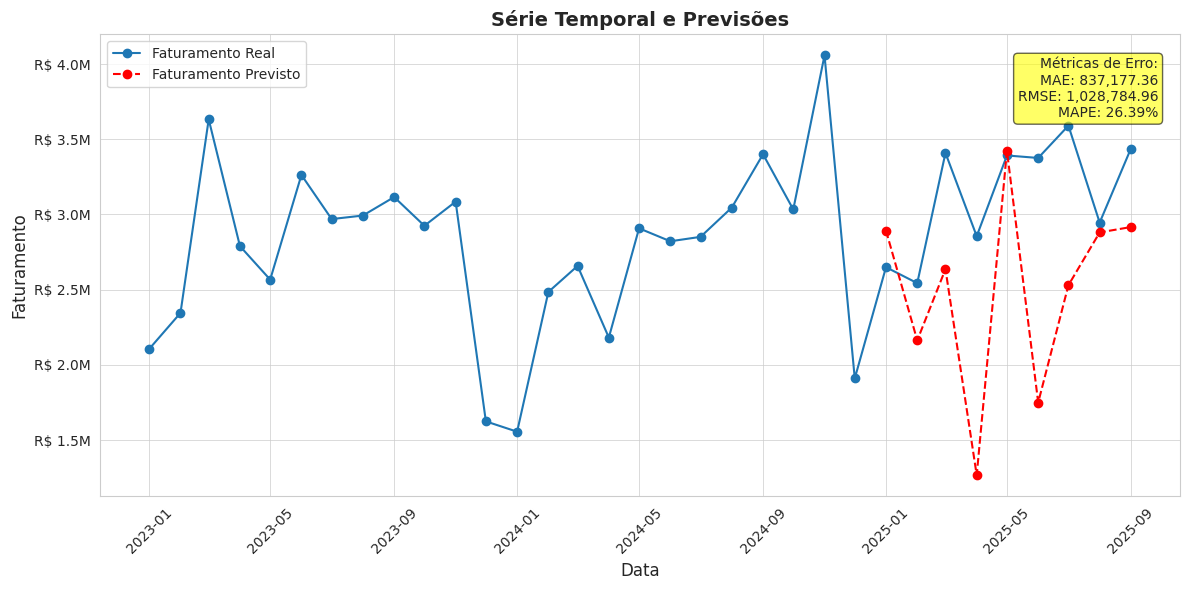

In [32]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax1,
    coluna,
    metricas_sarimax
)

### ARIMA(10, 1, 1) restrito

In [33]:
metricas_sarimax_sparse1, df_resultados_sarimax_sparse1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 606,375.48 | RMSE: 657,121.12 | MAPE: 19.16%


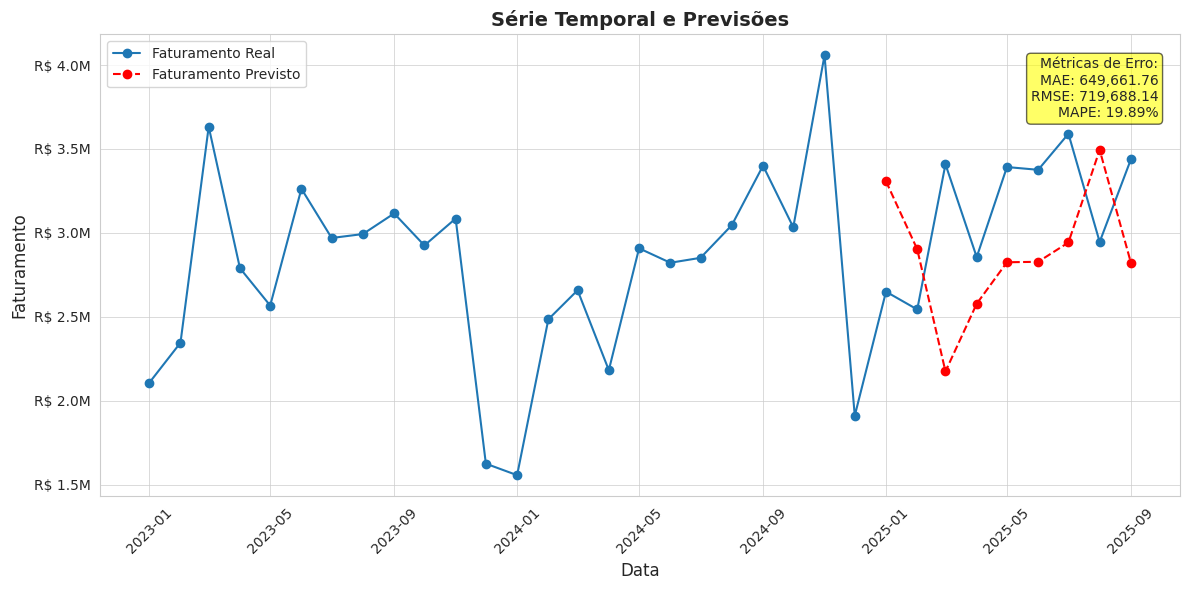

In [34]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse1,
    coluna,
    metricas_sarimax_sparse
)

### ARIMA(10, 1, 1) log

In [35]:
coluna = 'log_faturamento'
metricas_sarimax_log1, df_resultados_sarimax_log1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 686,125.23 | RMSE: 844,325.76 | MAPE: 22.05%


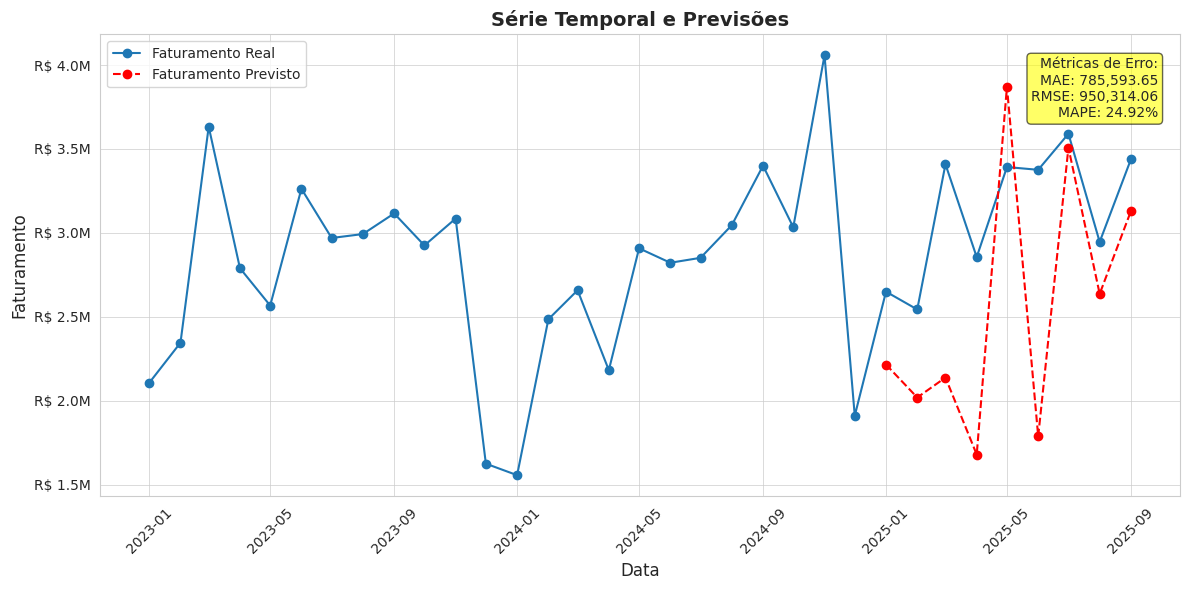

In [36]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_log1,
    coluna,
    metricas_sarimax_log
)

### ARIMA(10, 1, 1) log restrito

In [57]:
coluna = 'log_faturamento'
metricas_sarimax_sparse_log1, df_resultados_sarimax_sparse_log1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 483,044.76 | RMSE: 588,160.61 | MAPE: 14.72%


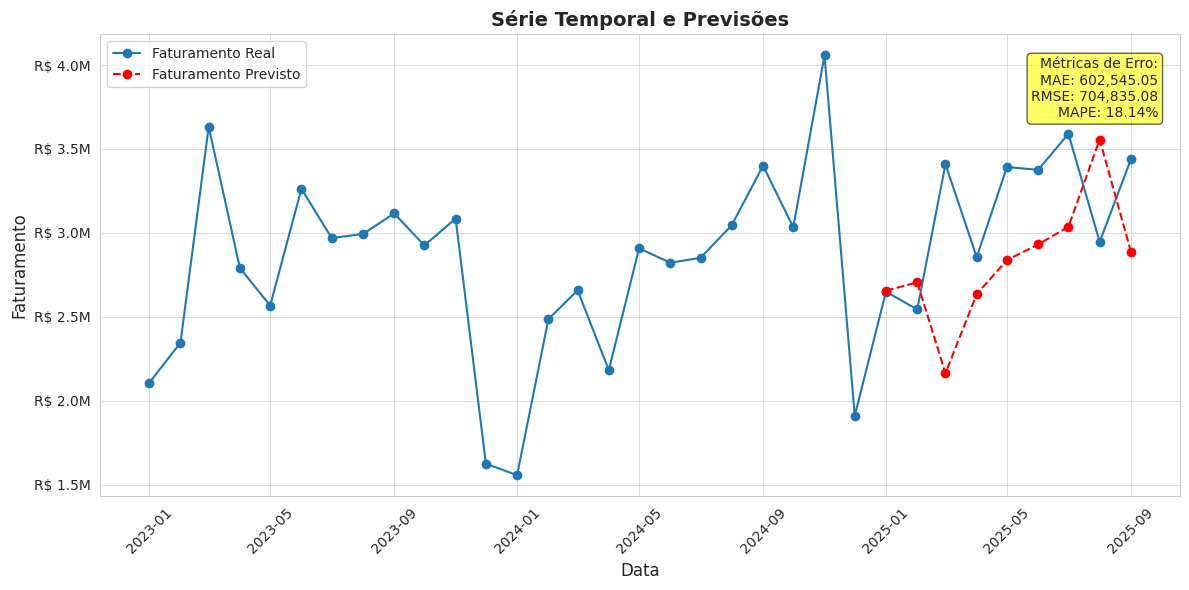

In [58]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_log1,
    coluna,
    metricas_sarimax_sparse_log
)